---
### 7.2.1 最小二乘拟合
最小二乘原则：残差的平方和最小
#### 1. 线性最小二乘法
拟合函数以一个函数系的线性组合形式出现，拟合函数为为关于参数的线性函数
#### 2. 非线性最小二乘拟合
拟合函数不以其线性组合的形式出现，代入最小二乘原则，则转化为非线性函数的极小化问题
#### 3. 拟合函数的选择
作出数据散点图，从直观上选取合适的拟合函数

### 7.2.2 线性最小二乘法的 Python 实现
#### 1. 解线性方程的拟合参数
$\boldsymbol R\boldsymbol A=\boldsymbol Y$

`A = np.linalg.pinv(R) @ Y`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman + SimSun + WFM Sans SC']
plt.rcParams['mathtext.fontset']='stix'
# Times New Roman + SimSun + WFM Sans SC
# simsum宋体, times new roman -*, simhei黑体, kaiti楷体, 
# dengxian等线, fangsong仿宋, Microsoft Yahei微软雅黑
plt.rcParams['axes.unicode_minus']=False   
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

In [2]:
t0 = np.arange(8)
y0 = np.array([27.0, 26.8, 26.5, 26.3, 26.1, 25.7, 25.3, 24.8])
tbar = t0.mean()
ybar = y0.mean()
ahat = np.sum((t0-tbar)*(y0-ybar)) / np.sum((t0 - tbar)**2)
bhat = ybar - ahat*tbar
print(f'{ahat = }\n{bhat = }')

ahat = -0.30357142857142855
bhat = 27.125


In [3]:
R = np.vstack([t0, np.ones(len(t0))]).T     # 补一列 1，相当于 b*1
A = np.linalg.pinv(R) @ y0
print(A)

[-0.30357143 27.125     ]


#### 2. 拟合小行星运行轨道 (椭圆)
$$a_1x^2+a_2xy+a_3y^2+a_4x+a_5y=-1$$

In [4]:
data = np.loadtxt('../../07第7章  插值与拟合/data7_11.txt')
x0, y0 = data
R = np.vstack([x0**2, x0*y0, y0**2, x0, y0]).T
b = -np.ones(len(x0))
A = np.linalg.inv(R) @ b
print(A)

[ 0.05076623 -0.07021888  0.03812646 -0.45309109  0.26425697]


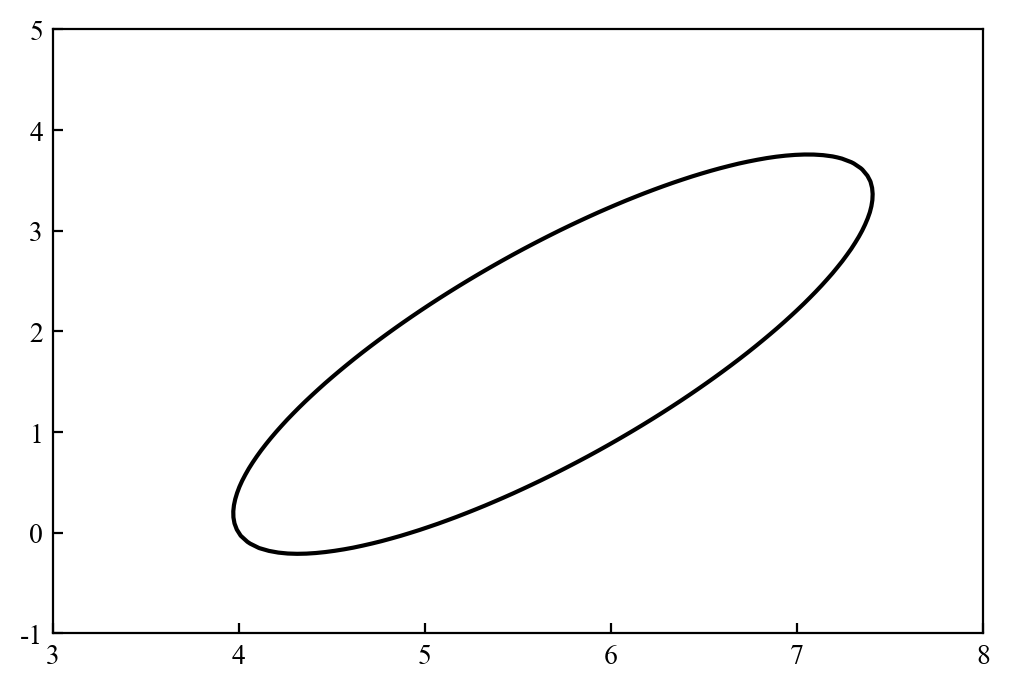

In [5]:
a1, a2, a3, a4, a5 = A
f = lambda x, y: a1*x**2 + a2*x*y + a3*y**2 + a4*x + a5*y
x = np.linspace(3, 8, 100)
y = np.linspace(-1, 5, 100)
X, Y = np.meshgrid(x, y)
z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, z, [-1], colors='k', linestyles='-')  # 取 z=-1的部分 (满足椭圆方程)
fig.show()

#### 3. 数学规划方法解拟合参数
$$y=a{\rm e}^x+b\ln x$$
其中 $a\geq 0, b\geq 0, a+b\leq 1$

In [6]:
import cvxpy as cp

x0, y0 = np.loadtxt('../../07第7章  插值与拟合/data7_12.txt')
R = np.vstack([np.exp(x0), np.log(y0)]).T

t = cp.Variable(2, nonneg=True)    # t[0] = a, t[1] = b
obj = cp.Minimize(cp.sum_squares(R @ t - y0))   # 最小二乘原则
cons = [cp.sum(t) <= 1]
prob = cp.Problem(obj, cons)
prob.solve(solver='GUROBI')
print(f'a = {t.value[0]}\nb = {t.value[1]}')

a = 0.0005695162610875718
b = 0.9994304837277954


#### 4. 多项式拟合 (对一元函数最简便)
$$y=k{\rm e}^{mt}\Rightarrow \ln y=\ln k+mt$$

In [7]:
t0, y0 = np.loadtxt('../../07第7章  插值与拟合/data7_13.txt')
lny0 = np.log(y0)
m, lnk = np.polyfit(t0, lny0, 1)     # 拟合 1次多项式，按次数从高到低返回系数
print(f'{lnk = }\n{m = }')

lnk = 4.363990407002682
m = -0.10368583918220013


### 7.2.3 非线性拟合的 Python 实现
> 均来自于 `scipy.optimize` 模块
#### 1. `curve_fit()`
```python
popt, pcov = curve_fit(f, t0, y0)
```
`f`：待拟合的函数 (由经验确定)

`popt`：拟合的参数

`pcov`：参数的协方差矩阵

In [8]:
from scipy.optimize import curve_fit

t0, y0 = np.loadtxt('../../07第7章  插值与拟合/data7_13.txt')
f = lambda t, k, m: k*np.exp(m*t)
popt, pcov = curve_fit(f, t0, y0)
k, m = popt
print(f'{k = }\n{m = }')

k = 78.45000388901484
m = -0.10355085417507265


In [9]:
th = np.array([5, 8])
yh = f(th, k, m)    # yh = f(th, *popt) 自动解包
print(th, yh, sep='\n')

[5 8]
[46.74499812 34.2626108 ]


#### 2. `least_squares()`
使用误差向量
```python
p = least_squares(err, x0, jac=jac, args=())
```
$$z={\rm e}^{-\dfrac{(x-\mu_1)^2+(y-\mu_2)^2}{2\sigma^2}}$$

In [10]:
from scipy.optimize import least_squares

m, n = 200, 300

# x：独立变量 (x, y, ...)
# u：待拟合参数 (mu1, mu2, s, ...)
# y：原始函数值

def func(u, x):    # 待拟合模型
    return np.exp(-((x[0]-u[0])**2 + (x[1]-u[1])**2) / (2*u[2]**2))

def err(u, x, y):   # 误差函数
    return func(u, x) - y

x = np.linspace(-6, 6, m)
y = np.linspace(-8, 8, n)
# 因为要拟合的是曲面，所以需要 meshgrid
X, Y = np.meshgrid(x, y)
x, y = X.flatten(), Y.flatten()
xy = np.array([x, y])
u0 = [1, 4, 6]
z0 = func(u0, xy)

np.random.seed(666)
z = z0 + 0.2*np.random.normal(size=z0.shape)
u = np.random.randn(3)
ret = least_squares(err, u, args=(xy, z))
ret

 active_mask: array([0., 0., 0.])
        cost: 1197.030837884383
         fun: array([-0.16565277, -0.09681369, -0.23551939, ...,  0.19908875,
       -0.15191671,  0.36225701])
        grad: array([ 1.70246873e-06, -2.28734524e-06, -2.69016530e-07])
         jac: array([[-0.01323532, -0.02264172,  0.06086007],
       [-0.01327647, -0.02290902,  0.06131015],
       [-0.0133154 , -0.02317713,  0.06175846],
       ...,
       [ 0.07801075,  0.06412201,  0.10610751],
       [ 0.07833145,  0.06359704,  0.10680596],
       [ 0.07863368,  0.06306997,  0.10749413]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 10
        njev: 10
  optimality: 2.2873452368808722e-06
      status: 2
     success: True
           x: array([1.01617413, 4.00260696, 5.99113639])

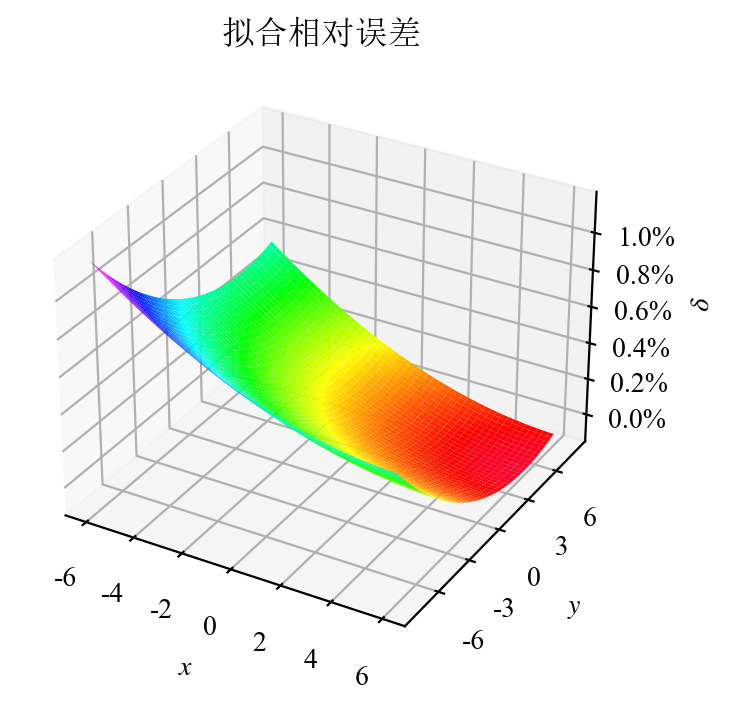

In [11]:
f = lambda x, y, m1, m2, s: np.exp(-((x-m1)**2 + (y-m2)**2) / (2*s**2))
z0 = f(X, Y, 1, 4, 6)
mu1, mu2, s = ret.x
z1 = f(X, Y, mu1, mu2, s)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, (z0 - z1)/z0, cmap='gist_rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel(r'$\delta$')
ax.set_title("拟合相对误差")

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_major_locator(MultipleLocator(3))
ax.zaxis.set_major_formatter(lambda x, pos: f'{x*100}%')

fig.show()

#### 3. 拟合一个分段函数
$$
y = 
\begin{cases}
a+bx,\quad x<k\\
c+dx,\quad x\geq k
\end{cases}
$$

In [12]:
from scipy.optimize import curve_fit

x0 = np.array([0.81,0.91,0.13,0.91,0.63,0.098,0.28,0.55,0.96,0.96,0.16,0.97,0.96])
y0 = np.array([0.17,0.12,0.16,0.0035,0.37,0.082,0.34,0.56,0.15,-0.046,0.17,-0.091,-0.071])

def func(x, a, b, c, d, k):
    return (a + b*x)*(x < k) + (c + d*x)*(x >= k)

LB, UB = [-np.inf]*4, [np.inf]*4
LB.append(x0.min())
UB.append(x0.max())
a, b, c, d, k = curve_fit(func, x0, y0, bounds=(LB, UB))[0]
print(f"{a = }\n{b = }\n{c = }\n{d = }\n{k = }")

a = -0.038085078374635505
b = 1.353802899377717
c = 1.23645816949357
d = -1.3006035933998539
k = 0.534


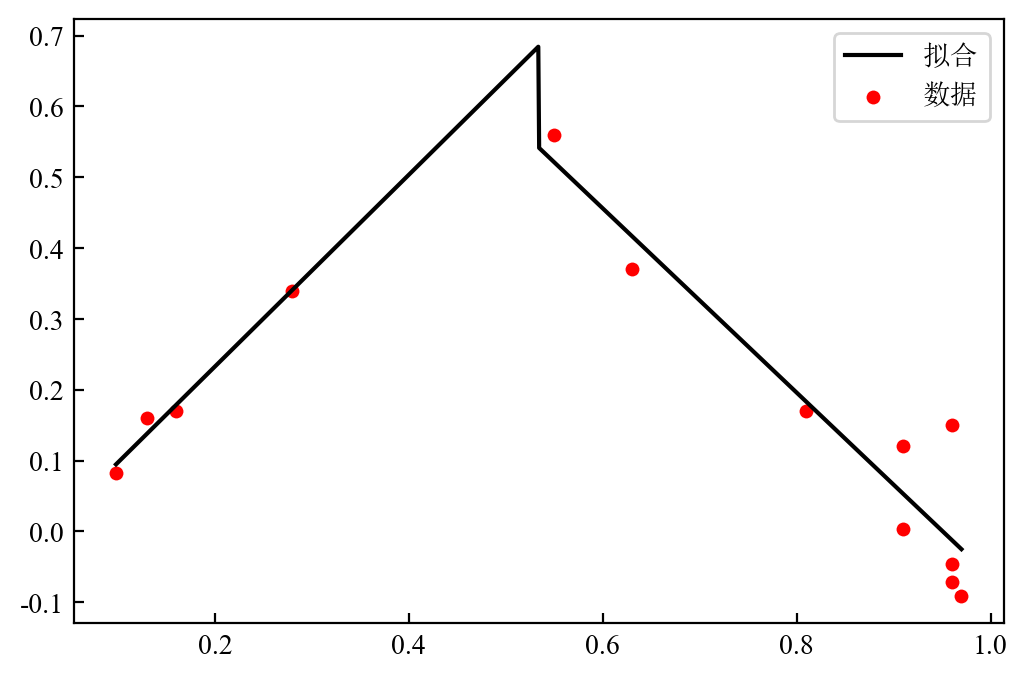

In [13]:
x = np.linspace(x0.min(), x0.max(), 1000)
y = func(x, a, b, c, d, k)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, label='拟合', color='k')
ax.scatter(x0, y0, marker='o', label='数据', edgecolor='w', facecolor='r')
ax.legend()
fig.show()

### 7.2.4 拟合和统计等库中的检验参数
|    检验参数     |        名称        |
| :-------------: | :----------------: |
|    $\rm SSE$    |     误差平方和     |
|    $\rm MSE$    |        方差        |
|   $\rm RMSE$    |     剩余标准差     |
|      $R^2$      | 判断系数，拟合优度 |
|    $\rm SST$    |      总平方和      |
|   $ \rm SSR$    |     回归平方和     |
| $\overline R^2$ |    调整判断系数    |